# Color Transfer Calculator

This notebook is used to extract the color checker patches from the digital and film images, and use the extracted patch RGB values to calculate color transfer functions from the digital RAW image to the scanned film image colors. This also implies an intermediate data linearization step for the scanned film data.

Note: This notebook relies on matplotlib widgets to provide a UI interface for user-guided color checker patch extraction.
Matplotlib widgets can sometimes be finicky and may require a second plot reload

In [1]:
%load_ext autoreload
%autoreload 2
# Enabling the `widget` backend.
# This requires jupyter-matplotlib a.k.a. ipympl.
# ipympl can be install via pip or conda.
%matplotlib widget
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from colorchecker import ColorChecker, ColorCheckerReading
from digitalimage import DigitalImage
from linearization import LinearExponential
from colortransfer import ColorTransfer

## TE226 Color checker
We start off by building a simple color tranfer function from photos of a TE226 Color checker backlit with a lamp of unknown illuminant characteristic

### Step 1: Model Color Checker

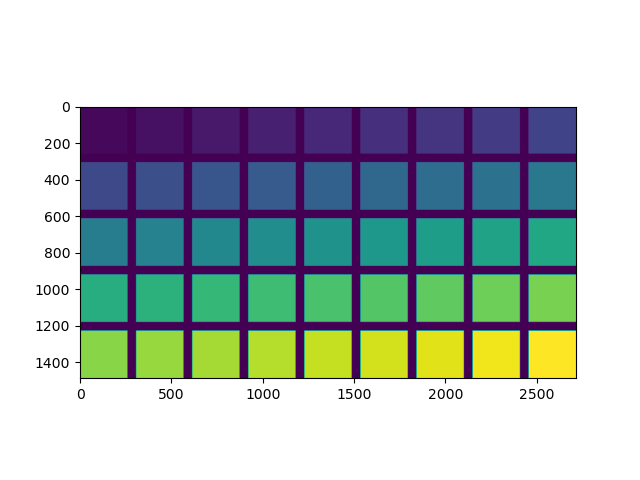

In [2]:
# borders are larger than the real color checker to build a margin to the edges of color patches
TE226 = ColorChecker(5, 9, 260, 47)
fig_checker = plt.figure()
plt.imshow(TE226.np_array)

### Step 2: Import digital image patches

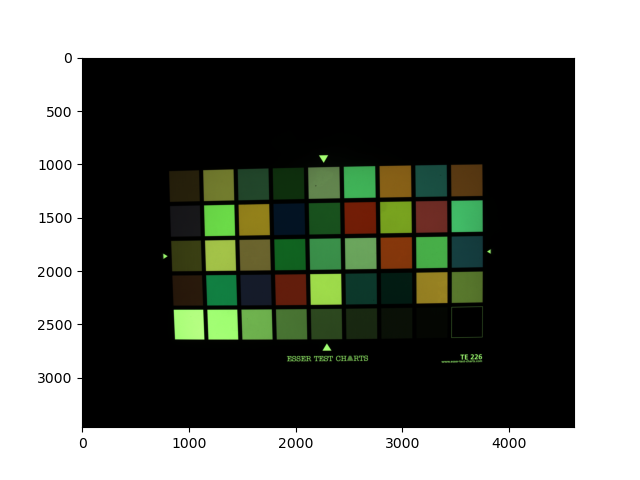

In [18]:
# exposure is corrected as the scanned image is more expose,
# and we don't want the calculated color transfer function to increase exposure too much
TE226_g81_img = DigitalImage("dataset\digital\P1480487.RW2", exposure=2)
plt.figure()
plt.imshow(TE226_g81_img.raw)

Output()

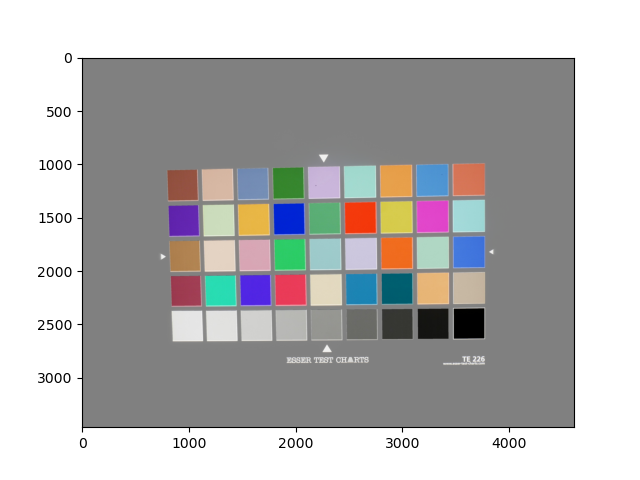

In [19]:
# select color checker location with UI interface. Reading is preloaded for ease of use if found in local files
# you can enlarge the matplotlib widget with the bottom right corner to make the color checker identification easier
path_TE226_G81_reading = "color_transfer_data/patches/TE226_G81.ccr"
TE226_g81_reading = ColorCheckerReading.load_if_exists(path_TE226_G81_reading, TE226_g81_img.raw, TE226)
TE226_g81_reading.locate_color_checker(TE226_g81_img.thumbnail)

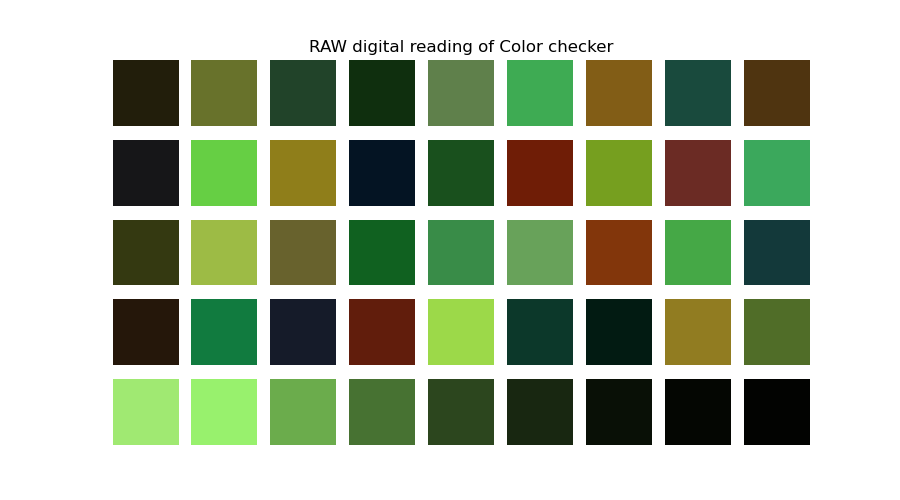

In [20]:
# check the reading
TE226_g81_reading.plot_patches("RAW digital reading of Color checker")

In [6]:
# Once you are happy with the reading, you can save it so you don't have to calculate it next time
TE226_g81_reading.save(path_TE226_G81_reading)

### Step 3: Import scanned film patch

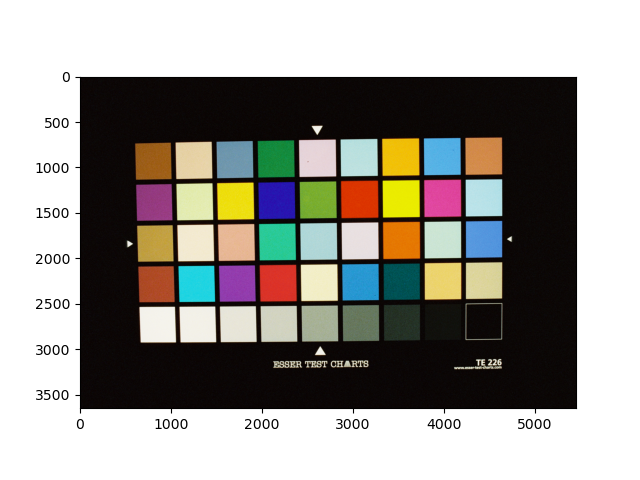

In [7]:
TE226_800t_file = Image.open("dataset/film/A002382raphael-R1-20-21.TIF")
TE226_800t = np.array(TE226_800t_file) / 255
plt.figure()
plt.imshow(TE226_800t)

Output()

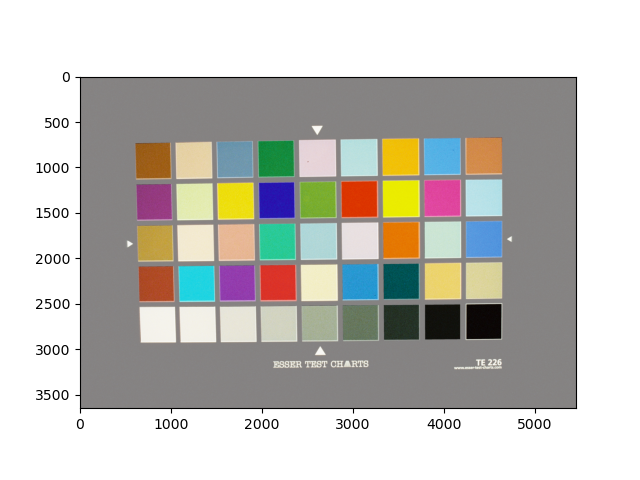

In [21]:
# extract patches
plt.close('all')
path_TE226_800t_reading = "color_transfer_data/patches/TE226_800t.ccr"
TE226_800t_reading = ColorCheckerReading.load_if_exists(path_TE226_800t_reading, TE226_800t, TE226)
TE226_800t_reading.locate_color_checker()

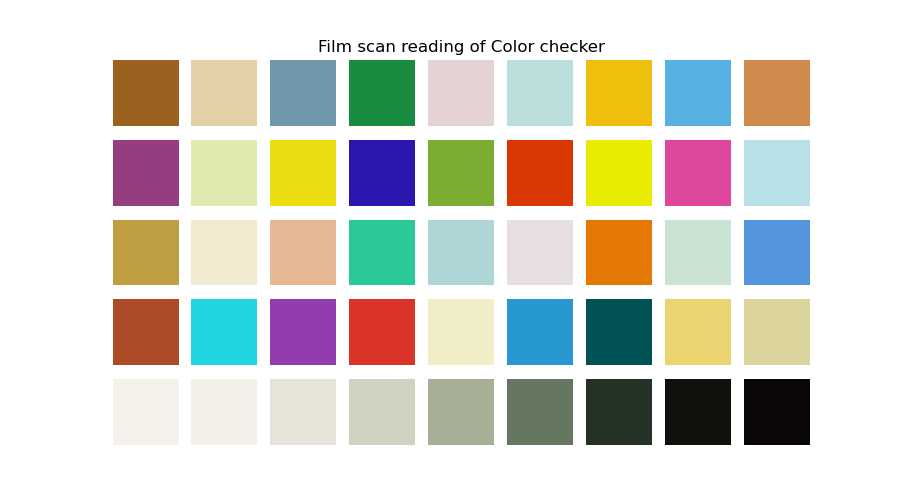

In [22]:
TE226_800t_reading.plot_patches("Film scan reading of Color checker")
TE226_800t_reading.save(path_TE226_800t_reading)

### Step 4: Linearize film scan

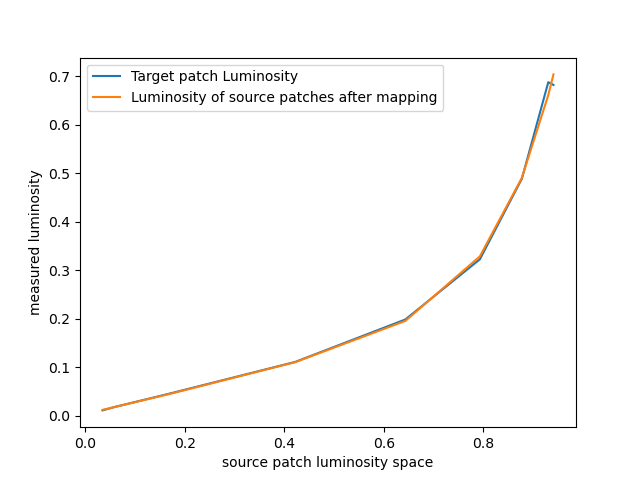

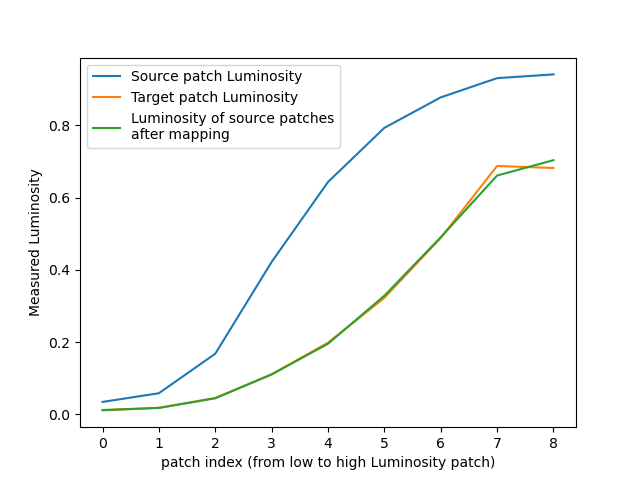

In [10]:
plt.close('all')
# this linearization function also encodes the dynamic range of the image,
# and which parts of the highlights and shadows of digital image will be clipped during inverse transformation after color transfer application.
# Therefore, set the exposure of your digital images during import to match which intensities you want clipped:
# The exposure of the Color checker image encodes how much the color transfer function will also change exposure,
# and the exposure of the image you want to apply the color transfer to defines what will be clipped in the final result
TE226_lfn = LinearExponential(TE226_800t_reading.patch_data[-9:], TE226_g81_reading.patch_data[-9:])
TE226_lfn.plot_mapping()
TE226_lfn.plot_luminosity()
TE226_lfn.save("color_transfer_data/linearization_functions/TE226.lfn")

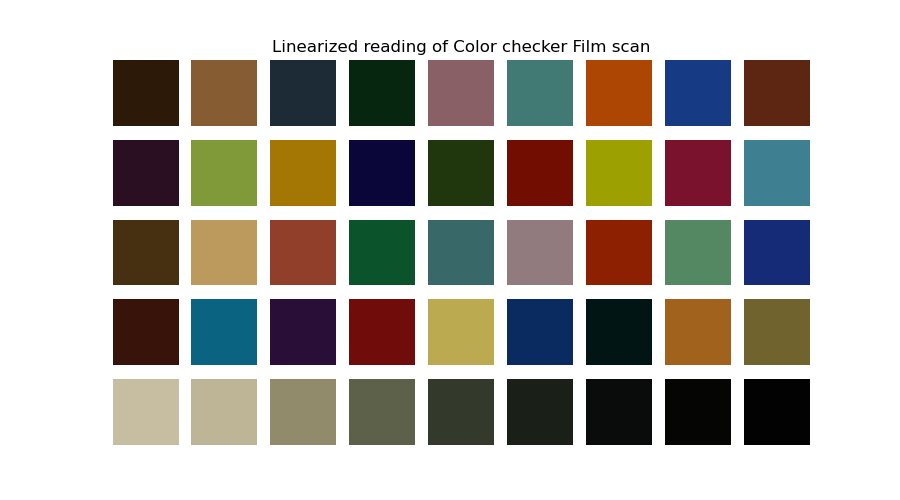

In [11]:
TE226_800t_linearized_reading = TE226_800t_reading.apply_transformation(TE226_lfn.apply)
TE226_800t_linearized_reading.plot_patches("Linearized reading of Color checker Film scan")

### Step 5: Calculate Color transfer function

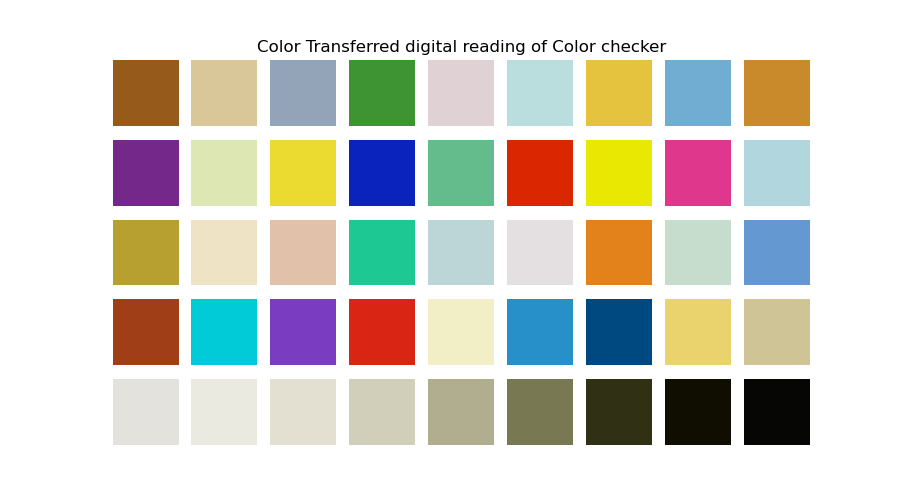

In [12]:
TE226_ctf = ColorTransfer(['r', 'g', 'b', 'rg', 'rb', 'gb', 'rr', 'gg', 'bb', 'rgb', '1'], TE226_g81_reading.patch_data, TE226_800t_linearized_reading.patch_data)
transferred_TE226_g81_reading = TE226_g81_reading.apply_new_image(TE226_ctf.apply(TE226_g81_img.raw, TE226_lfn.apply_inv))
transferred_TE226_g81_reading.plot_patches("Color Transferred digital reading of Color checker")

### Step 6: Save Color transfer function to file

In [13]:
TE226_ctf.save("color_transfer_data/transfer_functions/TE226.ctf")

# Paper Color Checker under different lightsources

We would like to see if we get better quality color transfer functions if we match the illuminant of the color transfer calculation photos, with the illuminant of the scene we are trying to color match.
To do so, we built 3 additional color transfer functions from images of printed sets of color patches (arranged like a color checker), for 4 different colors of sets of patches, under 3 illuminants

### Step 0: Build Color Checker Pattern

The patches of the model are much smaller than in reality to account for the paper not being completely flat in the image.

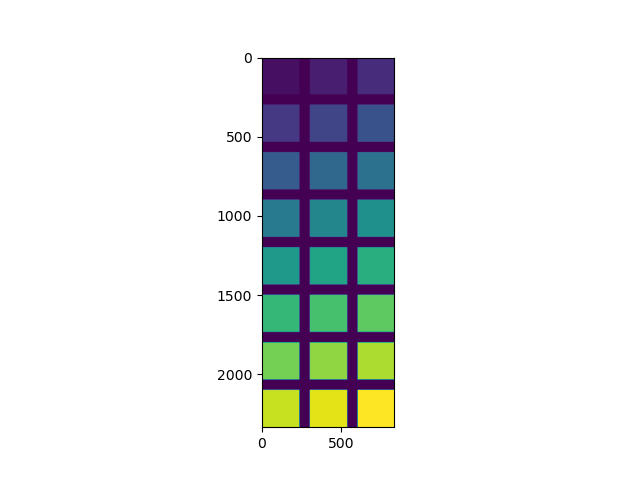

In [23]:
paper_patches = ColorChecker(8, 3, 235, 65)
plt.figure()
plt.imshow(paper_patches.np_array)

## Patches under "Blue" Light

### Step 1: capture digital patches

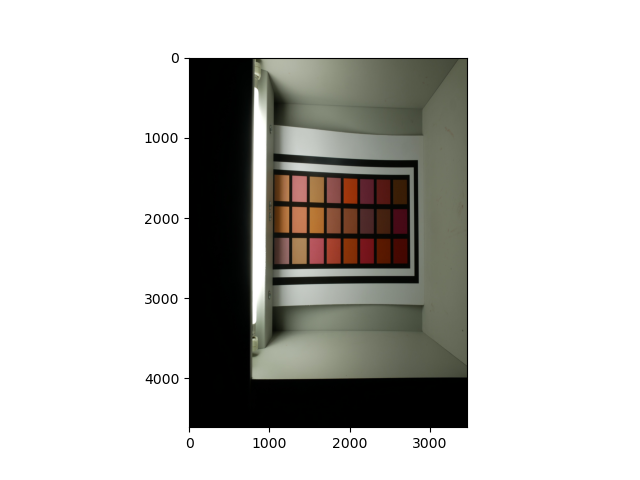

In [31]:
bluelight_patches1_g81_img = DigitalImage("dataset\digital\P1480476.RW2", exposure=2)
path_bluelight_patches1_g81 = "color_transfer_data/patches/bluelight_patches1_g81.ccr"
bluelight_patches1_g81_reading = ColorCheckerReading.load_if_exists(path_bluelight_patches1_g81, bluelight_patches1_g81_img.raw, paper_patches)
# plt.figure()
# plt.imshow(bluelight_patches1_g81_img.thumbnail)